In [203]:
import math
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

warnings.filterwarnings(action='ignore') 

# Load Data

In [204]:
# Read the dataset
data = pd.read_csv('sales_data.csv')
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [205]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76000 entries, 0 to 75999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                76000 non-null  object 
 1   Store ID            76000 non-null  object 
 2   Product ID          76000 non-null  object 
 3   Category            76000 non-null  object 
 4   Region              76000 non-null  object 
 5   Inventory Level     76000 non-null  int64  
 6   Units Sold          76000 non-null  int64  
 7   Units Ordered       76000 non-null  int64  
 8   Price               76000 non-null  float64
 9   Discount            76000 non-null  int64  
 10  Weather Condition   76000 non-null  object 
 11  Promotion           76000 non-null  int64  
 12  Competitor Pricing  76000 non-null  float64
 13  Seasonality         76000 non-null  object 
 14  Epidemic            76000 non-null  int64  
 15  Demand              76000 non-null  int64  
dtypes: f

In [206]:
# Show statistical summary of numerical features
data.describe()

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Promotion,Competitor Pricing,Epidemic,Demand
count,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000,76000.000000
mean,301.062842,88.827316,89.090645,67.726028,9.087039,0.328947,69.454029,0.200000,104.317158
std,226.510161,43.994525,162.404627,39.377899,7.475781,0.469834,40.943818,0.400003,46.964801
min,0.000000,0.000000,0.000000,4.740000,0.000000,0.000000,4.290000,0.000000,4.000000
25%,136.000000,58.000000,0.000000,31.997500,5.000000,0.000000,32.620000,0.000000,71.000000
50%,227.000000,84.000000,0.000000,64.500000,10.000000,0.000000,65.700000,0.000000,100.000000
75%,408.000000,114.000000,121.000000,95.830000,10.000000,1.000000,97.932500,0.000000,133.000000
max,2267.000000,426.000000,1616.000000,228.030000,25.000000,1.000000,261.220000,1.000000,430.000000


In [207]:
# Convert 'Date' column to datetime and sort the data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by=['Store ID', 'Product ID', 'Date'])
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
100,2022-01-02,S001,P0001,Electronics,North,93,71,0,65.63,5,Snowy,0,73.66,Winter,0,84
200,2022-01-03,S001,P0001,Electronics,North,274,142,229,68.55,15,Snowy,1,80.73,Winter,0,132
300,2022-01-04,S001,P0001,Electronics,North,132,42,0,61.66,10,Snowy,0,54.88,Winter,0,67
400,2022-01-05,S001,P0001,Electronics,North,319,129,0,59.56,25,Snowy,1,57.34,Winter,0,110


# EDA

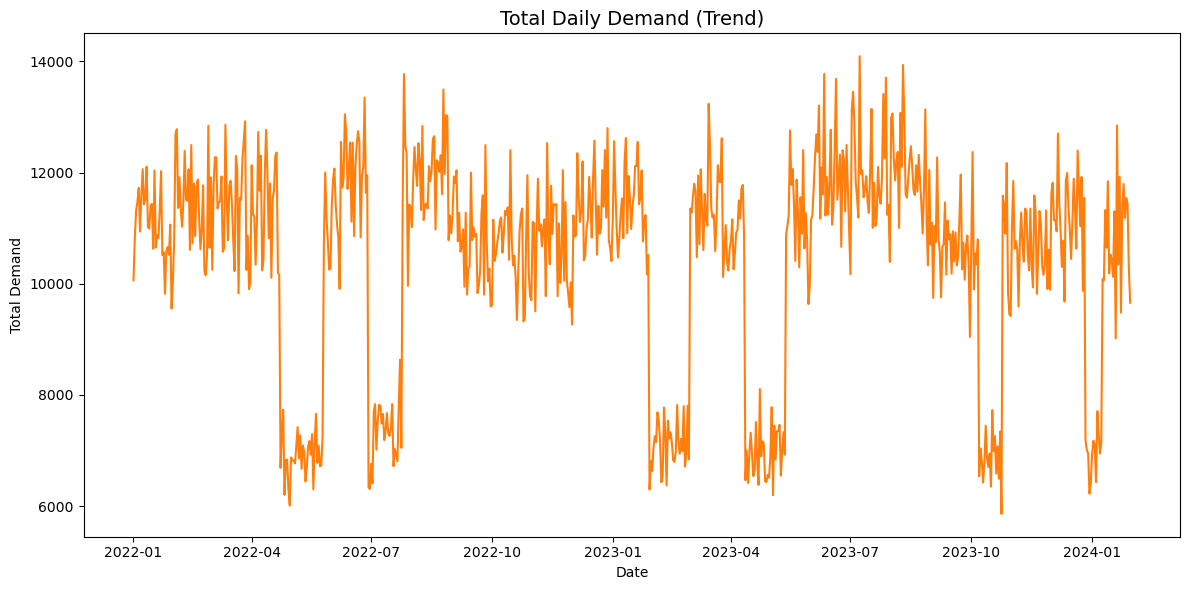

In [208]:
# Visualize total daily demand to identify trends 

daily_demand = data.groupby('Date')['Demand'].sum().reset_index()


plt.figure(figsize=(12, 6))
plt.plot(daily_demand['Date'], daily_demand['Demand'], color='tab:orange')
plt.title('Total Daily Demand (Trend)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Demand')

plt.tight_layout()
plt.show()

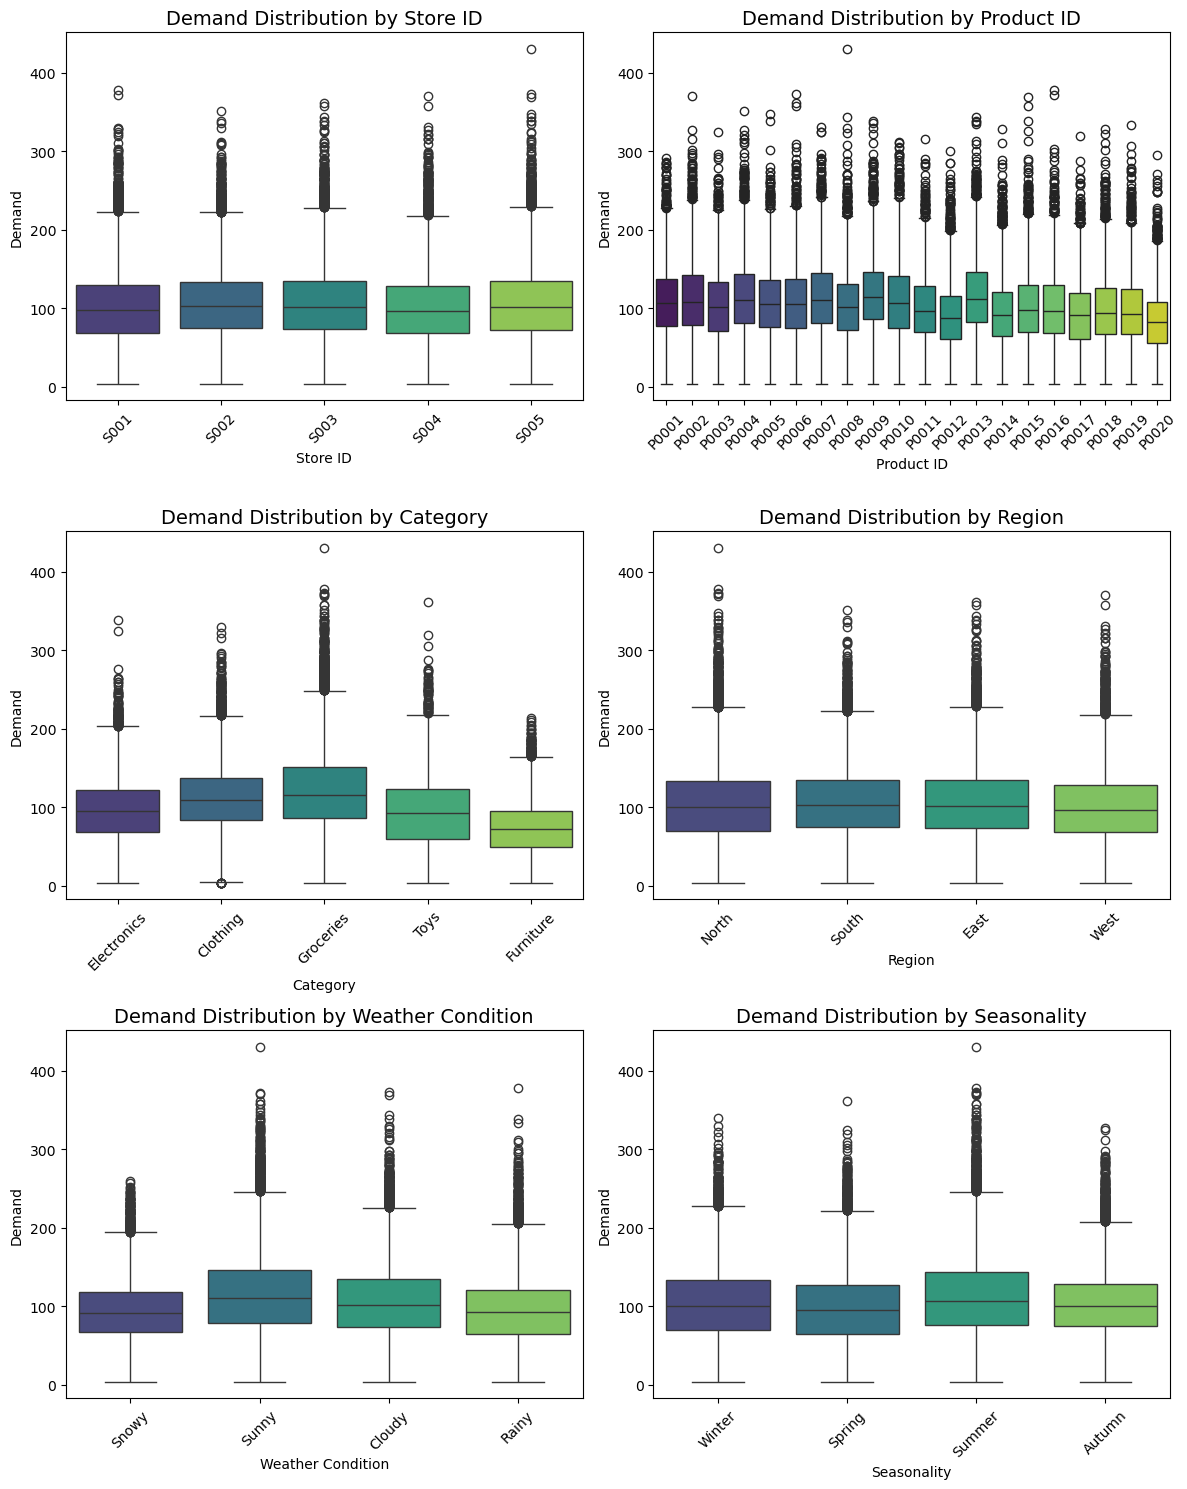

In [209]:
# Visualize categorical feature distributions with respect to Demand

n_features = data.select_dtypes(include=['object']).columns.tolist()
n_cols = 2
n_rows = math.ceil(len(n_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(n_features):
    sns.boxplot(data=data, x=feature, y='Demand', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Demand Distribution by {feature}', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Demand')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
                        

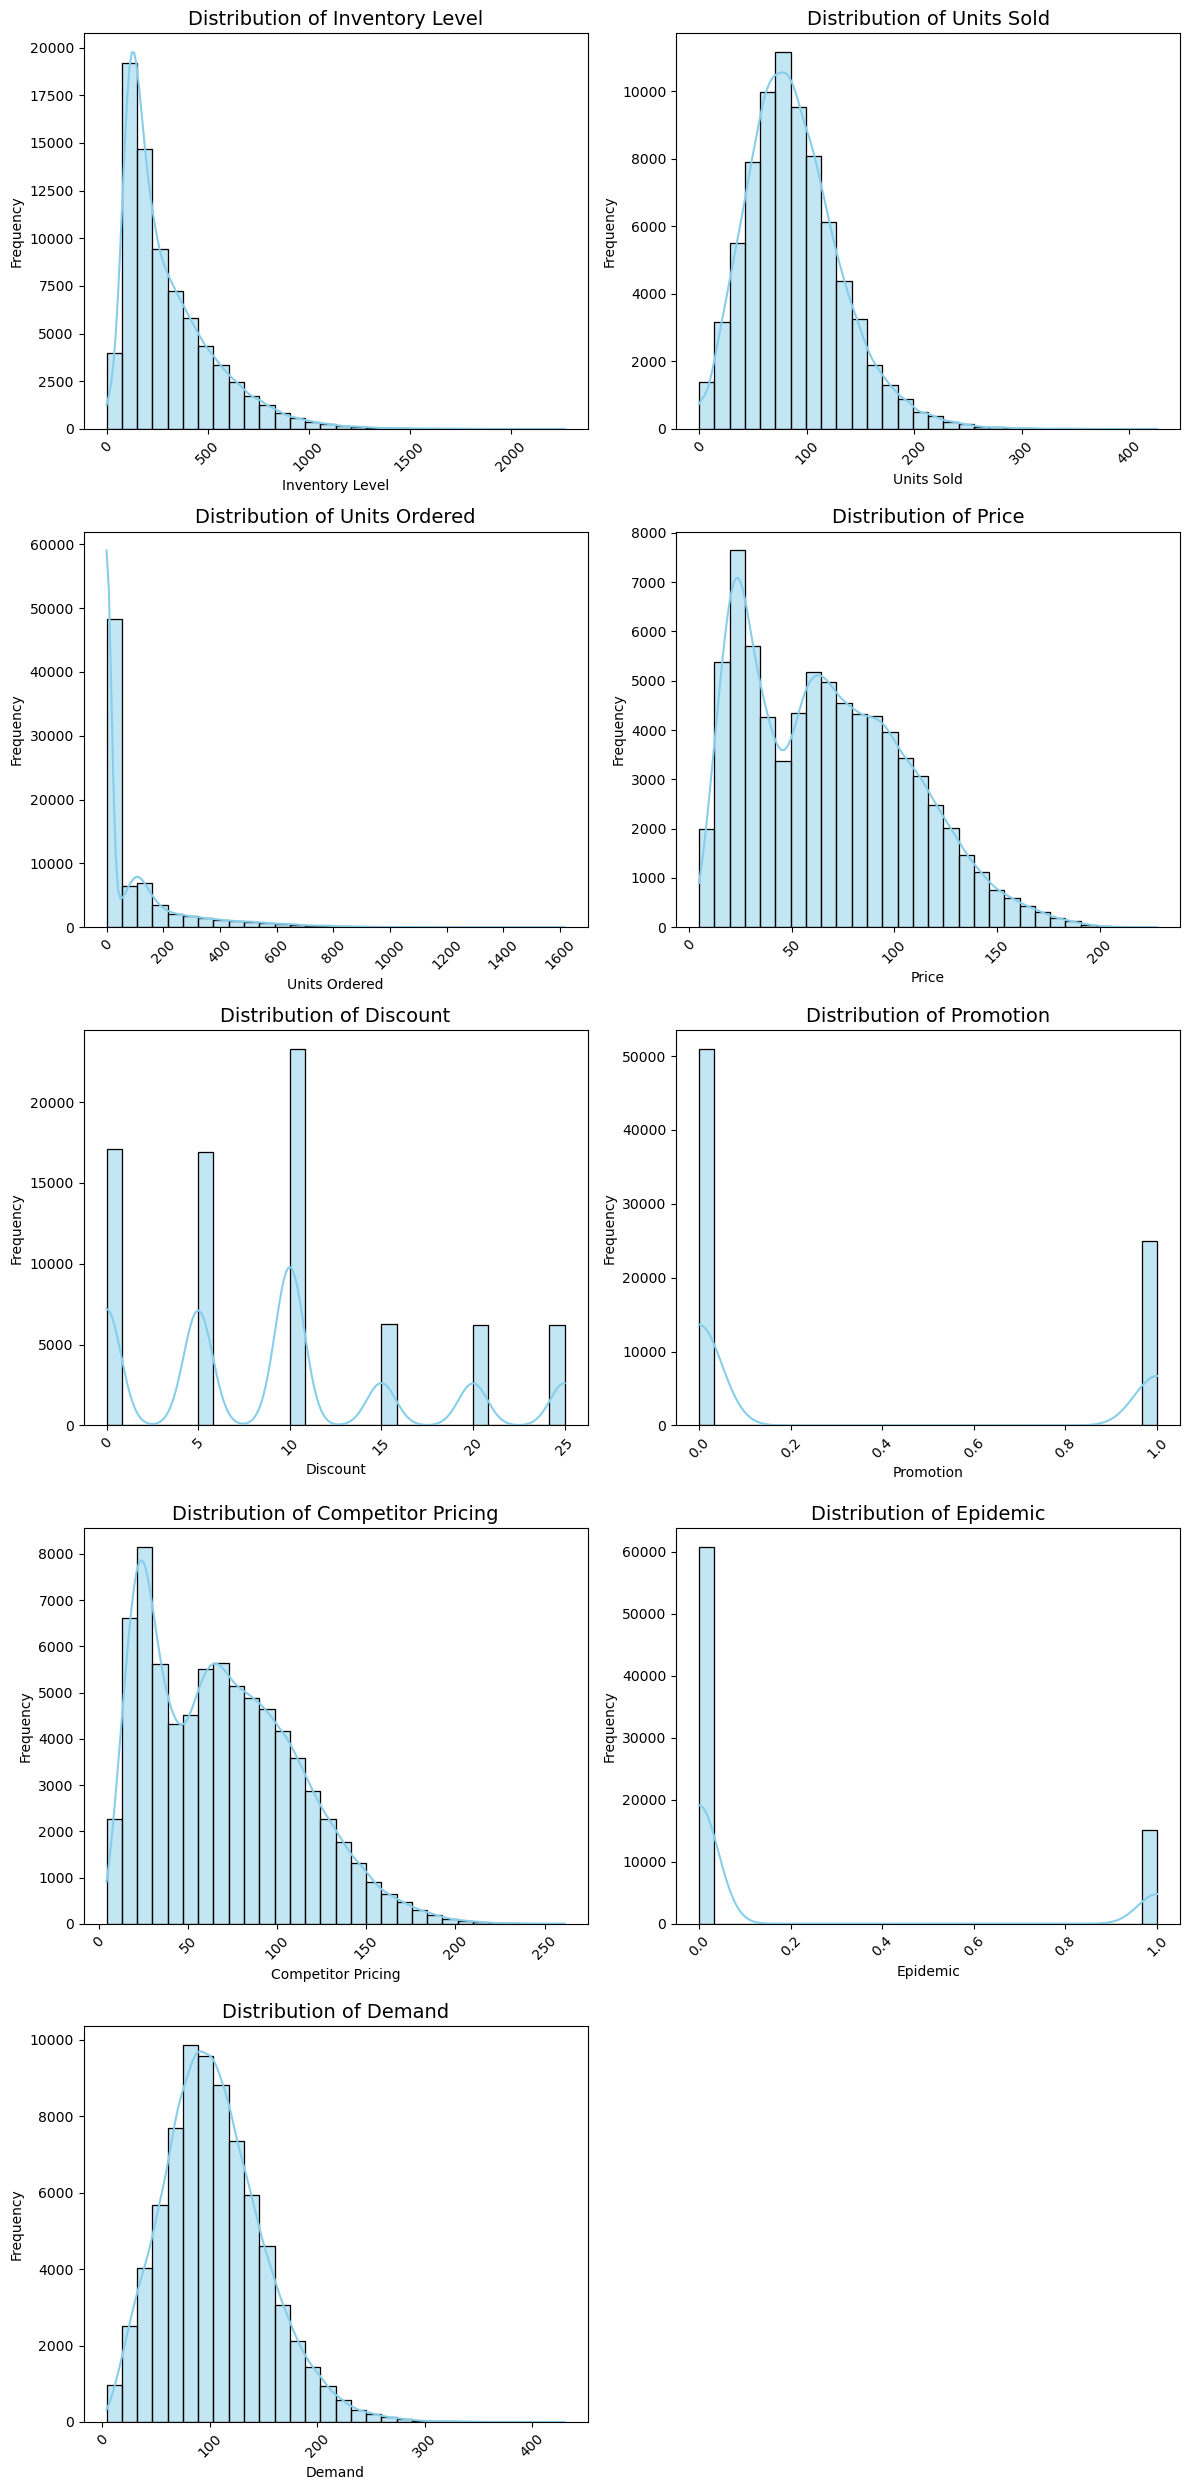

In [210]:
# Visualize numerical feature distributions

n_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
n_cols = 2
n_rows = math.ceil(len(n_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(n_features):
    sns.histplot(data[feature], kde=True, bins=30, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

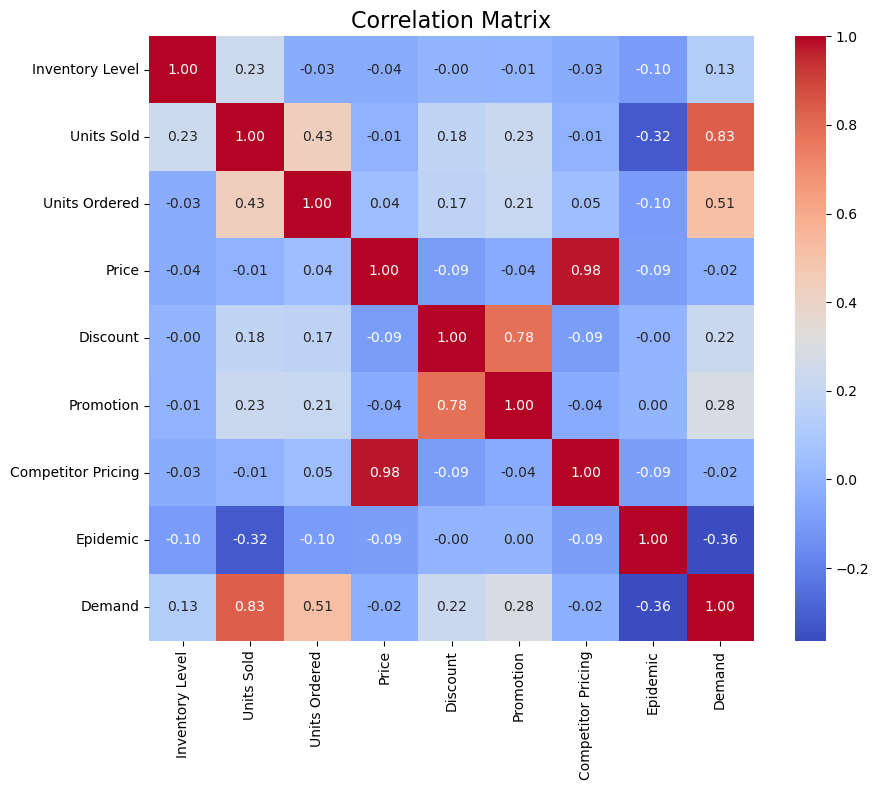

In [211]:
# Correlation matrix heatmap

corr = data.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

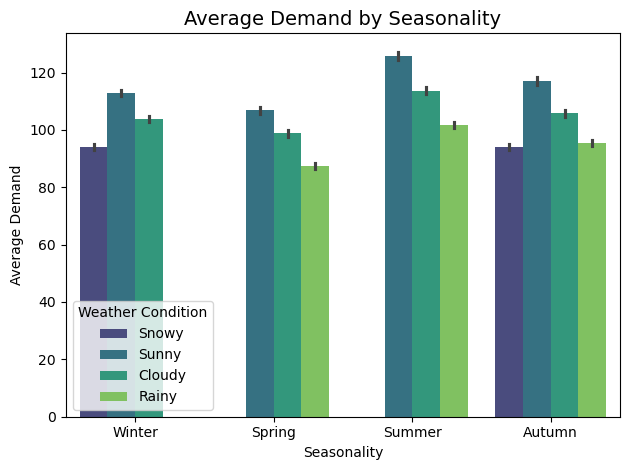

In [212]:
# Visualize Demand by Seasonality and Weather Condition

sns.barplot(data=data, x='Seasonality', y='Demand', hue='Weather Condition', palette='viridis')
plt.title('Average Demand by Seasonality', fontsize=14)
plt.xlabel('Seasonality')
plt.ylabel('Average Demand')
plt.tight_layout()
plt.show()

In [213]:
# Calculate and print stockout rate

stockouts = data[data['Demand'] > data['Inventory Level']]
stockout_rate = len(stockouts) / len(data) * 100
print(f'Stockout Rate: {stockout_rate:.2f}%')

Stockout Rate: 13.68%


# Feature Engineering

In [ ]:
# Feature Engineering
def feature_engineering(df):
    data = df.copy()
    
    # Create date-related features
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Interaction and derived features
    data['Season_Weather'] = data['Seasonality'] + '_' + data['Weather Condition']
    data['Price_Ratio'] = data['Price'] / data['Competitor Pricing']
    
    # Lag features for Demand
    group_cols = ['Store ID', 'Product ID']
    for lag in [1, 7, 30]:
        data[f'Demand_Lag_{lag}'] = data.groupby(group_cols)['Demand'].shift(lag)

    # Rolling statistics for Demand 
    for window in [7, 30]:
        data[f'RollingMean_{window}'] = data.groupby(group_cols)['Demand'].rolling(window).mean().reset_index(0, drop=True).reset_index(0, drop=True)
        data[f'RollingStd_{window}'] = data.groupby(group_cols)['Demand'].rolling(window).std().reset_index(0, drop=True).reset_index(0, drop=True)

    # Remove 'Units Sold' after feature engineering
    data = data.drop('Units Sold', axis=1)

    # Create Price Segment feature
    data['Price_Segment'] = data['Price'].apply(lambda x: 'Low' if x < 50 else 'High')
    data = data.drop('Price', axis=1)

    # Drop rows with any remaining NaN values
    data = data.dropna().reset_index(drop=True)
        
    return data

# Preprocessing

In [ ]:
# Custom Transformer for Store-Level Statistics

class StoreStatsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.store_stats = None
        self.monthly_stats = None
        self.global_mean = 0
        
    def fit(self, X, y=None):
        temp_df = X.copy()
        temp_df['Target_Temp'] = y 
        
        self.global_mean = y.mean()
        
        # Learning store-level statistics
        self.store_stats = temp_df.groupby('Store ID')['Target_Temp'].agg(
            Store_Mean='mean',
            Store_Std='std',
            Store_Q95=lambda x: np.quantile(x, 0.95)
        ).reset_index()
        self.store_stats['Store_CV'] = self.store_stats['Store_Std'] / (self.store_stats['Store_Mean'] + 1e-6)
        
        # Learning monthly average demand
        self.monthly_stats = temp_df.groupby('Month')['Target_Temp'].mean().rename('Monthly_Avg_Demand').reset_index()
        
        return self
    
    def transform(self, X):
        data = X.copy()
        
        # Merge learned statistics
        if self.store_stats is not None:
            data = pd.merge(data, self.store_stats, on='Store ID', how='left')
            
        if self.monthly_stats is not None:
            data = pd.merge(data, self.monthly_stats, on='Month', how='left')
            
        # Fill missing values with global mean or zeros
        fill_values = {
            'Store_Mean': self.global_mean, 'Store_Std': 0, 
            'Store_Q95': self.global_mean, 'Store_CV': 0,
            'Monthly_Avg_Demand': self.global_mean
        }
        data.fillna(fill_values, inplace=True)
        
        return data

In [216]:
# Define feature lists

cat_features = [
    'Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality', 'Season_Weather', 'Price_Segment'
]

num_features = [
    'Discount', 'Promotion', 'Competitor Pricing', 'Epidemic', 'IsWeekend', 'Price_Ratio', 
    'Demand_Lag_1', 'Demand_Lag_7', 'Demand_Lag_30', 
    'RollingMean_7', 'RollingStd_7', 'RollingMean_30', 'RollingStd_30', 
    'Store_Mean', 'Store_Std', 'Store_Q95', 'Store_CV', 'Monthly_Avg_Demand'
]
log_features = ['Inventory Level', 'Units Ordered']

In [217]:
# Define preprocessing pipelines for different feature types

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    # OneHotEncoder(handle_unknown='ignore', drop='if_binary')
    TargetEncoder(smooth=10.0)
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

In [218]:
# Combine preprocessing pipelines using ColumnTransformer

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", num_pipeline, num_features),
    ("log", log_pipeline, log_features)
], remainder='drop')

preprocessor

,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [219]:
# Create regression model

xgb_regressor = XGBRegressor(
    tree_method='hist', 
    random_state=42, 
    n_jobs=-1
)

xgb_regressor

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [220]:
# Define the full pipeline

full_pipeline = Pipeline([
    ('store_stats', StoreStatsTransformer()),
    ('preprocessor', preprocessor),
    ('xgbregressor', xgb_regressor)
])

In [221]:
# Prepare training and testing datasets

data_base = feature_engineering(data)
data_base = data_base.sort_values('Date').reset_index(drop=True)

train_size = int(len(data_base) * 0.8)
train_data = data_base.iloc[:train_size].dropna()
test_data = data_base.iloc[train_size:]

X_train = train_data.drop(columns=['Demand', 'Date'])
y_train_log = np.log1p(train_data['Demand'])

X_test = test_data.drop(columns=['Demand', 'Date'])
y_test = test_data['Demand']

In [222]:
# Hyperparameter Tuning with Time Series Cross-Validation

param_dist = {
    'xgbregressor__n_estimators': [100, 300, 500, 1000, 1500],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
    'xgbregressor__max_depth': [4, 6, 8, 10],
    'xgbregressor__subsample': [0.7, 0.8, 0.9],
    'xgbregressor__colsample_bytree': [0.7, 0.8, 0.9],
    'xgbregressor__reg_alpha': [0, 0.1, 1], 
    'xgbregressor__reg_lambda': [1, 2, 5]   
}

tsvc = TimeSeriesSplit(n_splits=10) 

search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=tsvc,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train_log)

print(f"\nBest parameters : {search.best_params_}")
print(f"Best CV Score (RMSE): {-search.best_score_:.4f}")

Fitting 10 folds for each of 20 candidates, totalling 200 fits

Best parameters : {'xgbregressor__subsample': 0.8, 'xgbregressor__reg_lambda': 1, 'xgbregressor__reg_alpha': 1, 'xgbregressor__n_estimators': 1000, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.9}
Best CV Score (RMSE): 0.0646


In [223]:
# Train final models with best hyperparameters

best_params = search.best_params_
clean_params = {k.split('__')[1]: v for k, v in best_params.items()}

feature_pipeline = make_pipeline(StoreStatsTransformer(), preprocessor)
X_train_processed = feature_pipeline.fit_transform(X_train, y_train_log)
X_test_processed = feature_pipeline.transform(X_test)

# Point prediction model
xgb_point = XGBRegressor(objective='reg:squarederror', **clean_params, tree_method='hist', n_jobs=-1, random_state=42)
xgb_point.fit(X_train_processed, y_train_log)

# Quantile prediction models for uncertainty estimation

# Lower quantile model (2.5th percentile)
xgb_lower = XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.025, **clean_params, tree_method='hist', n_jobs=-1, random_state=42)
xgb_lower.fit(X_train_processed, y_train_log)

# Upper quantile model (97.5th percentile)
xgb_upper = XGBRegressor(objective='reg:quantileerror', quantile_alpha=0.975, **clean_params, tree_method='hist', n_jobs=-1, random_state=42)
xgb_upper.fit(X_train_processed, y_train_log)

# Make predictions and inverse transform to original scale
pred_real = np.expm1(xgb_point.predict(X_test_processed))
lower_real = np.expm1(xgb_lower.predict(X_test_processed))
upper_real = np.expm1(xgb_upper.predict(X_test_processed))

# Ensure no negative predictions
pred_real = np.maximum(pred_real, 0)
lower_real = np.maximum(lower_real, 0)

In [224]:
# KPI Reporting Function

def print_kpi_report(y_true, y_pred, baseline_pred=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n[XGBRegressor Model Performance Report]")
    print(f"------------------------------------------------")
    print(f"1. MAPE : {mape:.2f}%")
    print(f"   -> {'Success (Target < 10%)' if mape < 10 else 'Target Missed (> 10%)'}")
    print(f"2. RMSE : {rmse:.2f}")

    if baseline_pred is not None:
        base_rmse = np.sqrt(mean_squared_error(y_true, baseline_pred))
        improv = (base_rmse - rmse) / base_rmse * 100
        print(f"------------------------------------------------")
        print(f"3. Improvement vs Baseline : {improv:.2f}%")
        print(f"   -> {'Success (> 15% Improvement)!' if improv >= 15 else '⚠️ Insufficient Improvement (< 15%)'}")

In [225]:
# Evaluate model performance against baseline
baseline_preds = test_data['Demand_Lag_7'].fillna(method='bfill')
print_kpi_report(y_test, pred_real, baseline_preds)


[XGBRegressor Model Performance Report]
------------------------------------------------
1. MAPE : 16.81%
   -> Target Missed (> 10%)
2. RMSE : 18.35
------------------------------------------------
3. Improvement vs Baseline : 66.43%
   -> Success (> 15% Improvement)!


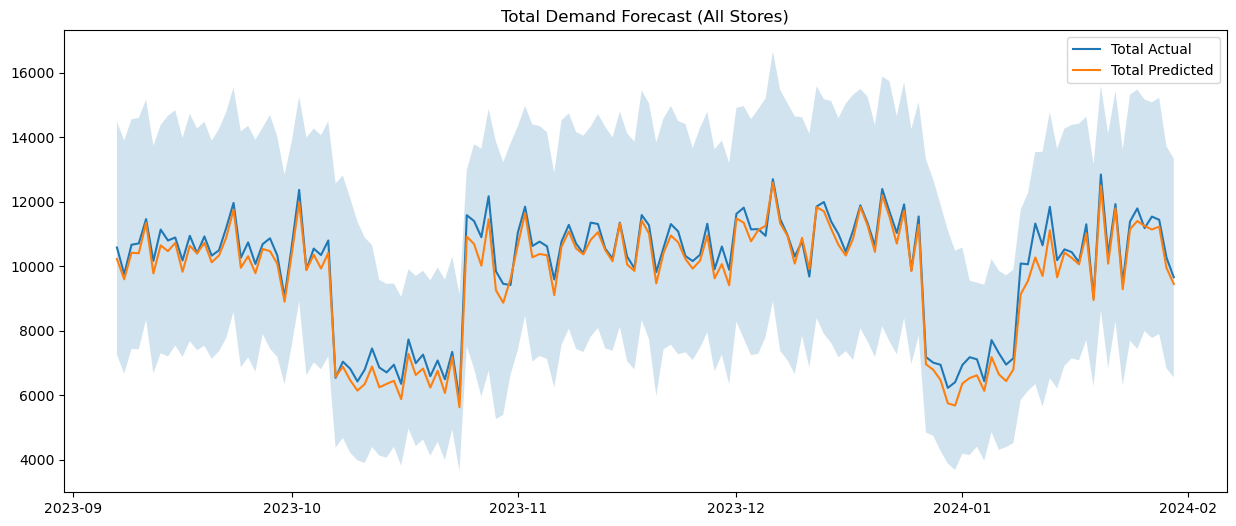

In [226]:
# Visualize final predictions with uncertainty intervals

results_df = pd.DataFrame({
    'Date': test_data['Date'],
    'Actual': y_test,
    'Predicted': pred_real,
    'Lower_95': lower_real,
    'Upper_95': upper_real
}).sort_values('Date')

daily_total = results_df.groupby('Date')[['Actual', 'Predicted', 'Lower_95', 'Upper_95']].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(daily_total['Date'], daily_total['Actual'], label='Total Actual')
plt.plot(daily_total['Date'], daily_total['Predicted'], label='Total Predicted')

plt.fill_between(daily_total['Date'], daily_total['Lower_95'], daily_total['Upper_95'], alpha=0.2)
plt.title('Total Demand Forecast (All Stores)')
plt.legend()
plt.show()

In [227]:
avg_safety_stock = (daily_total['Upper_95'] - daily_total['Predicted']).mean()
print(f"[Summary] Average Daily Safety Stock Required: {avg_safety_stock:,.0f} Units")

[Summary] Average Daily Safety Stock Required: 3,908 Units


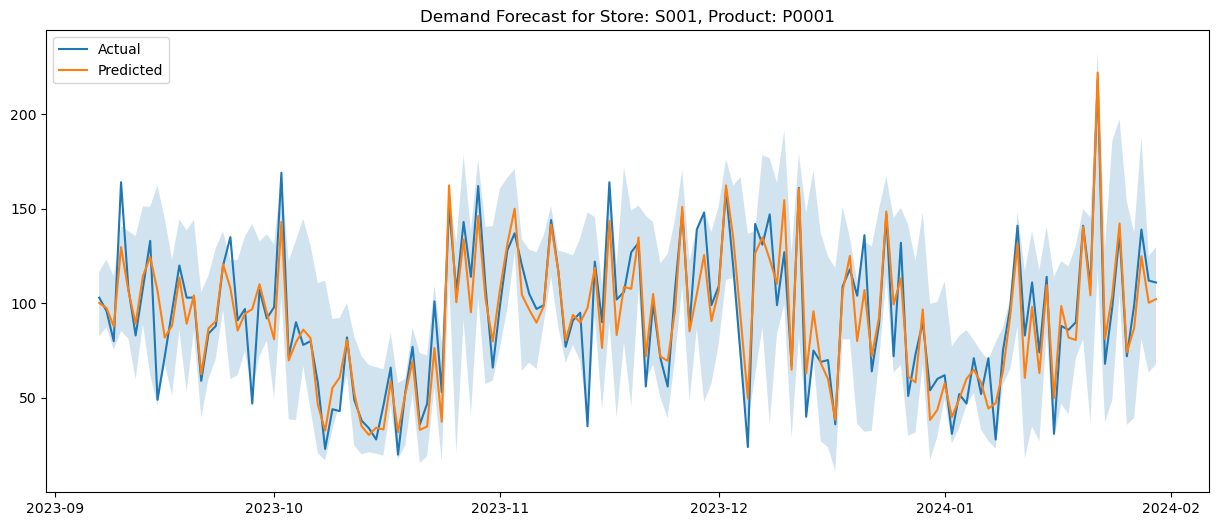

In [228]:
target_store = 'S001' 
target_product = 'P0001'
plot_df = results_df[(test_data['Store ID'] == target_store) & (test_data['Product ID'] == target_product)]

plt.figure(figsize=(15, 6))
plt.plot(plot_df['Date'], plot_df['Actual'], label='Actual')
plt.plot(plot_df['Date'], plot_df['Predicted'], label='Predicted')
plt.fill_between(plot_df['Date'], plot_df['Lower_95'], plot_df['Upper_95'], alpha=0.2)
plt.title(f'Demand Forecast for Store: {target_store}, Product: {target_product}')
plt.legend()
plt.show()

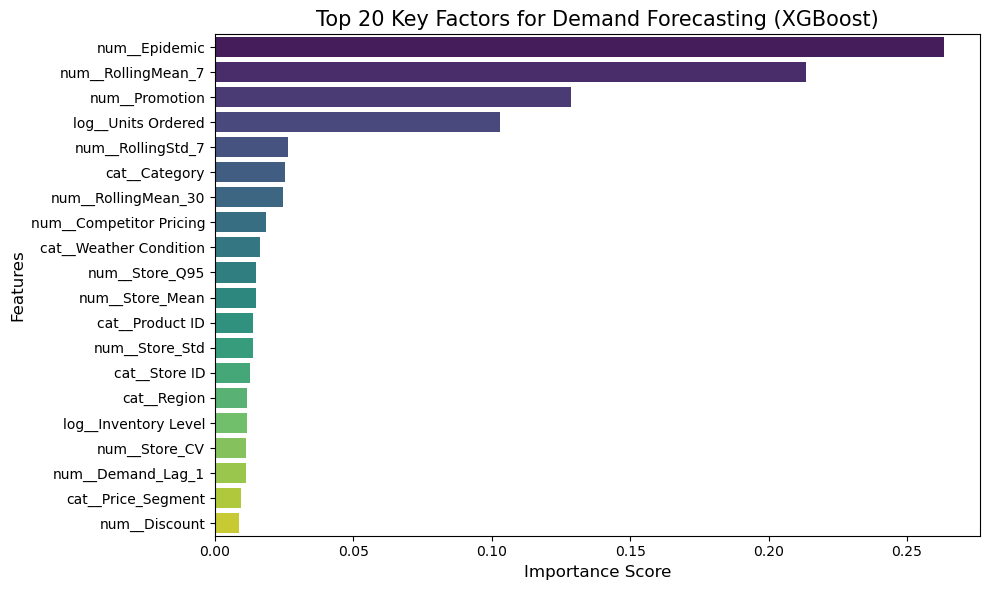

In [229]:
best_model = search.best_estimator_

feature_importances = best_model["xgbregressor"].feature_importances_
feature_importances.round(2)
feature_names = best_model['preprocessor'].get_feature_names_out()

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_importance.head(20), palette='viridis')

plt.title('Top 20 Key Factors for Demand Forecasting (XGBoost)', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()